# English Premier League sports-betting model

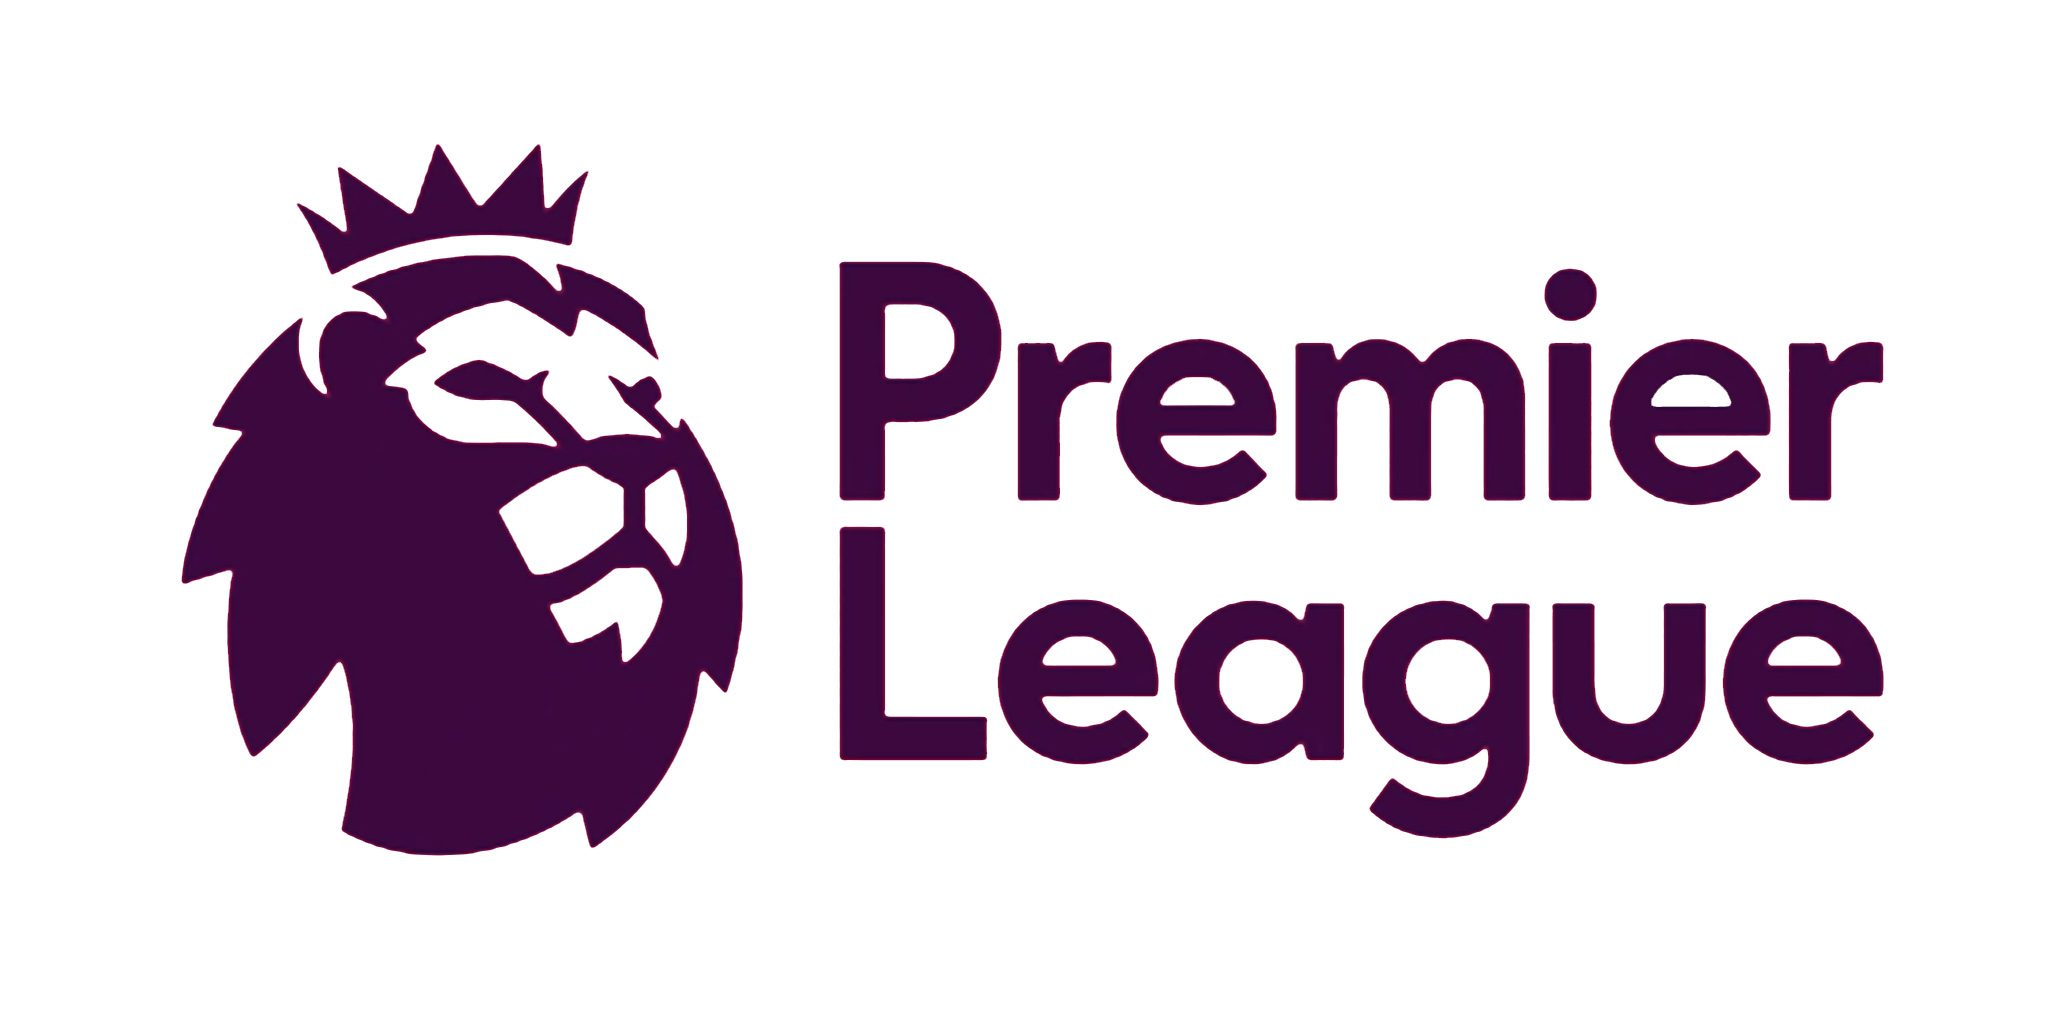

## Overview
In this project, my goal was to find the best classification algorithm to predict the full-time result of a Premier League football/soccer match. I start by importing the necessary libraries, cleaning/preprocessing the data, and building a simple, baseline model. I want to accurately classify the match result to help sports-bettors make better decisions and increase their chances of winning the bets they place. That way, instead of the bettor losing money (which can often be the case), they make money instead. Through an iterative modeling process, I found that a logistic regression model performed the best when classifying the result of a Premier League match. Some recommendations from my analysis include live-betting on the home team when they are winning at half-time because when leading at half-time, home teams go on to win the game at an 81% rate.

## Business Problem
Bettors are looking for a model that can be used to help them make more informed decisions when placing their bets on Premier League matches. Traditionally, most sports-bettors have only relied on their own biases but with the help of data, their chances of winning their bets can increase. For general sports bettors who gamble as a hobby, this model should not be relied on as a source to make money.

## Data Understanding
The dataset used was from Kaggle. I used the match data from the start of the 2003/2004 season up to October of the 2021/2022 season. Most of the columns in the dataset are in-game statistics provided at the end of each match. In addition, the original dataset did not provide the betting favorite based on the moneyline. I used a sports-betting website to identify the moneyline favorite in each game and inserted this information into the dataset manually.

## Data Preprocessing and Cleaning

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
# reading in the data
df = pd.read_excel('/Users/schoollaptop/Documents/FLATIRON2021/CAPSTONE/results.xlsm')
df.head()

,Season,DateTime,HomeTeam,AwayTeam,HomeML,DrawML,AwayML,ML_Favorite,Home_Favorite?,FTHG,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,2003-04,2004-02-11T00:00:00Z,Birmingham,Everton,-105.0,215.0,229.0,Birmingham,1.0,3,...,11,3,8,11,10,14,1,0,0,0
1,2003-04,2004-02-11T00:00:00Z,Blackburn,Newcastle,150.0,210.0,138.0,Newcastle,0.0,1,...,7,7,8,6,12,10,0,0,0,0
2,2003-04,2004-02-11T00:00:00Z,Charlton,Tottenham,110.0,215.0,195.0,Charlton,1.0,2,...,14,10,10,4,13,14,3,0,0,0
3,2003-04,2004-02-11T00:00:00Z,Fulham,Aston Villa,102.0,215.0,210.0,Fulham,1.0,1,...,6,3,6,5,16,17,2,1,1,0
4,2003-04,2004-02-11T00:00:00Z,Liverpool,Man City,-172.0,240.0,383.0,Liverpool,1.0,2,...,7,3,6,3,7,8,0,0,0,0


It looks like the Home Moneyline (HomeML), Draw Moneyline (DrawML), and Away Moneyline (AwayML) odds are only provided for about 400 games. It is probably safe to get rid of these columns altogether because the dataset provides the betting favorite already in the column, 'ML_Favorite'.

In [3]:
df = df.drop(['HomeML','DrawML','AwayML','Home_Favorite?'], axis=1)

Now I will rename some of the columns to make them easier to understand

In [4]:
df.columns

Index(['Season', 'DateTime', 'HomeTeam', 'AwayTeam', 'ML_Favorite', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST',
       'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'],
      dtype='object')

In [5]:
df.rename(columns={'FTHG':'FullTime_HomeGoals',
                   'FTAG':'FullTime_AwayGoals',
                   'FTR':'FullTime_Result',
                   'HTHG':'HalfTime_HomeGoals',
                   'HTAG':'HalfTime_AwayGoals',
                   'HTR':'HalfTime_Result',
                   'HS':'Home_Shots',
                   'AS':'Away_Shots',
                   'HST':'Home_ShotsOnTarget',
                   'AST':'Away_ShotsOnTarget',
                   'HC':'Home_Corners',
                   'AC':'Away_Corners',
                   'HF':'Home_Fouls',
                   'AF':'Away_Fouls',
                   'HY':'Home_YellowCs',
                   'AY':'Away_YellowCs',
                   'HR':'Home_RedCs',
                   'AR':'Away_RedCs'}, inplace=True)

And finally, I will change the 'FullTime_Result' and 'HalfTime_Result' columns so that instead of strings of 'H', 'D', and 'A' (Home, Draw, Away), they will be 2, 1, and 0 respectively.

Full Time Result column explained:
- 2 = Home win
- 1 = Draw
- 0 = Away win

Half Time Result column explained:
- 2 = Home team winning at halftime
- 1 = Draw/tie at halftime
- 0 = Away team winning at halftime

In [6]:
# map a dictionary to convert strings to integers
# Full Time Result
df['FullTime_Result'] = df['FullTime_Result'].map({'H': 2,
                                                   'D': 1,
                                                   'A': 0})

# map a dictionary to convert strings to integers
df['HalfTime_Result'] = df['HalfTime_Result'].map({'H': 2,
                                                   'D': 1,
                                                   'A': 0})

## Feature Engineering

Some matches did not provide whether or not the home team was the favorite to win the game. It would be interesting to have this data for all of the matches so we will create a new column of the same name but have it be filled with booleans (True/False) and later replace them with 1s and 0s respectively

In [7]:
df['HomeTeam_Favorite'] = (df['HomeTeam'] == df['ML_Favorite'])

In [8]:
# map a dictionary to replace True and False with 1 and 0, respectively
df['HomeTeam_Favorite'] = df['HomeTeam_Favorite'].map({True: 1,
                                                 False: 0})

<b>HomeTeam_Favorite</b> explained:
- 1: Home team was the betting favorite to win the game
- 0: Away team was the betting favorite to win the game

<b>Conversion Rate</b> is calculated as the number of goals divided by the total number of shots. We will create a column for both the Home and Away team.

In [9]:
# Home Conversion Rate
df['Home_ConversionRate'] = round((df['FullTime_HomeGoals'] / df['Home_Shots']) * 100, 0)

# Away Conversion Rate
df['Away_ConversionRate'] = round((df['FullTime_AwayGoals'] / df['Away_Shots']) * 100, 0)

<b>Shots On Target percentage (%)</b> new column for each row based on what percentage of their total shots were shots on target

In [10]:
# Home Shots on Target (SoT percentage)
df['Home_SoT%'] = round((df['Home_ShotsOnTarget'] / df['Home_Shots']), 2)

# Away Shots on Target (SoT percentage)
df['Away_SoT%'] = round((df['Away_ShotsOnTarget'] / df['Away_Shots']), 2)

<b>Did the team that was favored to win (betting favorite) actually end up winning?</b>

In [11]:
# creating a Pandas series by using a for loop that determines whether the home team or the away team was the
# betting favorite in the match. I decided to use integers because strings are more difficult to work with.
# I am appending the integer 2 because that is what is used to identify the home team in 'FullTime_Result'
# After creating this 'favorites' column, I will identify whether or not the favored team actually won

favorites = []

for match in range(0,6657):
    # if the home team is favored, append a 2
    if df['HomeTeam'][match] == df['ML_Favorite'][match]:
        favorites.append(2)
    # if the away team is favored, append a 0
    else:
        favorites.append(0)

In [12]:
# converting the favorites list to a Pandas series so it can be easily
# added onto our original dataframe
favorites = pd.Series(favorites)

In [13]:
df['Favorites'] = favorites

<b>'Favorites'</b> column explained:
- 2 = Home Team favored to win the match
- 0 = Away Team favored to win the match

In [14]:
# using np.where to fill in 1 for when a favored team wins and 0 for when a favored team loses OR draws
df['Favorite_Winner'] = np.where((df['FullTime_Result'] == df['Favorites']), 1, 0)

<b>Favorite Winner</b> explained:
- 1 = the favored team ended up winning the game
- 0 = the favored team ended up losing OR drawing the game

We will not need the DateTime or Referee column because they are irrelevant for this analysis.

In [15]:
# dropping Datetime and Referee columns inplace
df.drop(['DateTime','Referee'], axis=1, inplace=True)

### Reducing the amount of dimensions in dataset: get rid of redundant and/or irrelevant features

Ultimately, we want the model to be able to predict 'FullTime_Result' so let's see which columns are most/least correlated with this target variable

In [25]:
df.corr()['FullTime_Result'].sort_values(ascending=False)

FullTime_Result        1.000000
FullTime_HomeGoals     0.627083
HalfTime_Result        0.602206
Home_ConversionRate    0.516405
HalfTime_HomeGoals     0.434142
Favorites              0.341739
HomeTeam_Favorite      0.341739
Favorite_Winner        0.327223
Home_ShotsOnTarget     0.309438
Home_SoT%              0.232717
Home_Shots             0.214076
Away_RedCs             0.090447
Home_Corners           0.053508
Away_Fouls             0.031430
Away_YellowCs          0.022138
Home_Fouls            -0.035652
Away_Corners          -0.042672
Home_YellowCs         -0.116995
Home_RedCs            -0.131621
Away_SoT%             -0.183807
Away_Shots            -0.252295
Away_ShotsOnTarget    -0.308754
HalfTime_AwayGoals    -0.424904
Away_ConversionRate   -0.497415
FullTime_AwayGoals    -0.635393
Name: FullTime_Result, dtype: float64

It will be better to have a dataset without all of the extra, redundant columns in it. For example, ShotsOnTarget and Shots are basically saying the same thing. In this case, we will keep ShotsOnTarget% because it is a percentage instead of a count of how many occurred in each match.

We will also take out FullTime_HomeGoals and FullTime_AwayGoals because this tells the model how many goals each team ended up with. This would essentially give away the FullTime_Result and cause the model to overfit to the training data. I am also dropping the amount of corner kicks for each time because that had minimal correlation with FullTime_Result. Additionally, I will take out Home and Away fouls because there was almost no relationship to FullTime_Result. Finally, I will be dropping the conversion rates because that also tells the model what percentage of a team's shots were goals. The higher the percentage for conversion rate, the more likely it is the team scored more goals than the other.

In [26]:
# new dataframe without redundant/irrelevant features called 'cleaned_df'
cleaned_df = df.drop(['FullTime_HomeGoals',
                      'FullTime_AwayGoals',
                      'Favorites',
                      'Home_Shots',
                      'Home_Corners',
                      'Away_Corners',
                      'Away_Shots',
                      'Season',
                      'ML_Favorite',
                      'Home_ConversionRate',
                      'Away_ConversionRate',
                      'Favorite_Winner',
                      'Home_ShotsOnTarget',
                      'Away_ShotsOnTarget',
                      'Home_Fouls',
                      'Away_Fouls'], axis=1)

<AxesSubplot:>

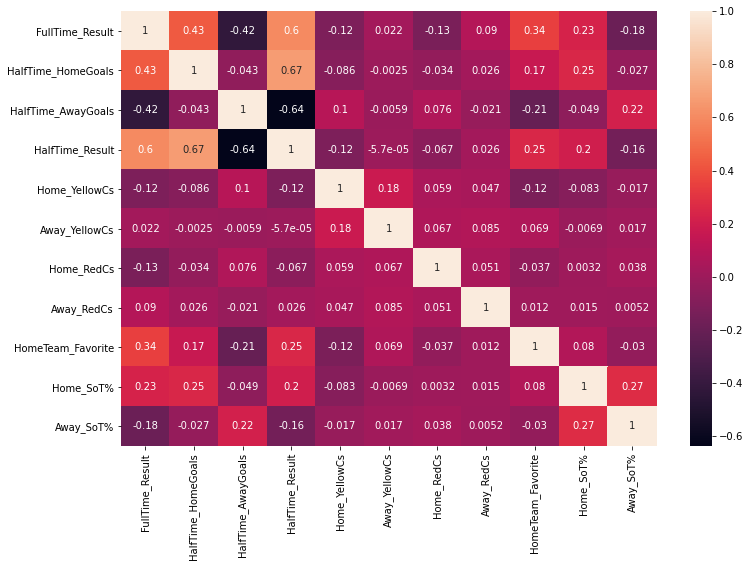

In [27]:
# new heatmap
plt.figure(figsize=(12,8))
sns.heatmap(cleaned_df.corr(),annot=True)

In [28]:
# correlation with full time result
cleaned_df.corr()['FullTime_Result'].sort_values(ascending=False)

FullTime_Result       1.000000
HalfTime_Result       0.602206
HalfTime_HomeGoals    0.434142
HomeTeam_Favorite     0.341739
Home_SoT%             0.232717
Away_RedCs            0.090447
Away_YellowCs         0.022138
Home_YellowCs        -0.116995
Home_RedCs           -0.131621
Away_SoT%            -0.183807
HalfTime_AwayGoals   -0.424904
Name: FullTime_Result, dtype: float64

After a cleaned_df.info(), I noticed that there were still 5 rows with missing values. These rows will be dropped because 5 represents less than 1% of the total data available.

In [29]:
# dropping rows with missing values (only 5 rows)
cleaned_df = cleaned_df.dropna()

## Modeling Process

### Scaling the columns with continous values using MinMaxScaler
For my baseline model I will be using a Decision Tree and I understand that you do not have to scale your values. However, I am choosing to scale them now because I am planning to test multiple models and some are distance-based (logistic regression and support vector machine)

In [30]:
# instance of MinMaxScaler
mm_scaler = MinMaxScaler()

# scaling the columns with continuous values using MinMaxScaler
cleaned_df[['Home_YellowCs','Away_YellowCs','Home_SoT%','Away_SoT%']] = mm_scaler.fit_transform(cleaned_df[['Home_YellowCs','Away_YellowCs','Home_SoT%','Away_SoT%']])

In [31]:
# target feature is FullTime_Result
# for baseline model, we will only input the column that identifies whether or not the home team was the favorite or not
X = cleaned_df[['HomeTeam_Favorite']]
y = cleaned_df['FullTime_Result']

### Train | Test split

In [32]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Baseline model - Decision Tree --> one feature 'HomeTeam_Favorite'

In [33]:
# instance of Decision Tree
base_tree = DecisionTreeClassifier()

# fitting model onto the training data
base_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [34]:
# generate predictions to evaluate model performance
tree_preds = base_tree.predict(X_test)

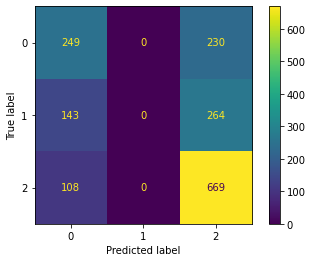

In [35]:
plot_confusion_matrix(base_tree, X_test, y_test)

In [36]:
print(classification_report(y_test, tree_preds))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       479
           1       0.00      0.00      0.00       407
           2       0.58      0.86      0.69       777

    accuracy                           0.55      1663
   macro avg       0.36      0.46      0.40      1663
weighted avg       0.41      0.55      0.47      1663



Metric being used --> <b>accuracy</b>

I am choosing <b>accuracy</b> as the metric to evaluate my models because as a sports-betting model, I am only interested in the predictions that the model gets correct. If the predictions are not correct/accurate, a bettor will lose the money that they wagered.

55% accuracy for a baseline model which is not terrible. Right now, the decision tree model classified a little over half of the Premier League match results correctly. The baseline model did not predict for any of the matches to end up as a draw because the HomeTeam_Favorite feature only identifies whether or not the betting favorite was the home team or the away team. Additionally, a draw/tie is never the betting favorite for a Premier League match.

### Model 2 - Decision Tree GridSearch --> trying to find optimal parameters
Adding in more features other than 'HomeTeam_Favorite'

In [37]:
# train_test_split
# NOT including full time home and away goals because that gives away the result but will include half time
# stats for live-betting considerations
X = cleaned_df.drop(['HomeTeam',
                     'AwayTeam',
                     #'FullTime_HomeGoals',
                     #'FullTime_AwayGoals',
                     #'Favorite_Winner',
                     'FullTime_Result'], axis=1)
                    
y = cleaned_df['FullTime_Result']

In [38]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
tree2 = DecisionTreeClassifier()

# parameter grid for GridSearch
tree_params = {
    'criterion': ['gini','entropy'],
    'max_depth': [1,3,5,10,20],
    'class_weight':[None,'balanced']
}


In [40]:
tree_grid = GridSearchCV(tree2, 
                         tree_params,
                         scoring='accuracy',
                         n_jobs=1,
                         cv=3)

In [41]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 10, 20]},
             scoring='accuracy')

In [42]:
# optimal parameters
tree_grid.best_params_

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5}

In [43]:
tree_grid_preds = tree_grid.predict(X_test)

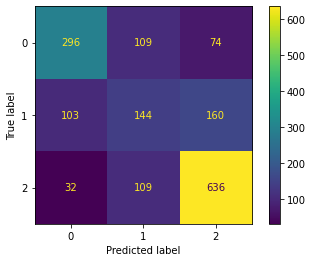

In [44]:
plot_confusion_matrix(tree_grid, X_test, y_test)

In [45]:
print(classification_report(y_test, tree_grid_preds))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65       479
           1       0.40      0.35      0.37       407
           2       0.73      0.82      0.77       777

    accuracy                           0.65      1663
   macro avg       0.61      0.60      0.60      1663
weighted avg       0.64      0.65      0.64      1663



The GridSearch for the Decision Tree model yielded an improvement of 10% in the model's accuracy. Overall, the model's accuracy is 65%. Next, I will try a different algorithm called Logistic Regression because this algorithm is relatively simple and interpretable. I am testing different models in an attempt to improve the accuracy score as much as possible.

We are already starting to repeat code for model performance evaluation. I will create a function to simplify this step.

In [46]:
def model_evaluation(model, y_true=y_test, X_test=X_test):
    model_predictions = model.predict(X_test)
    plot_confusion_matrix(model, X_test, y_test)
    print(classification_report(y_test, model_predictions))

### Model 3 - Logistic Regression with added features

In [47]:
log_model = LogisticRegression()

log_model.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.65      0.72      0.69       479
           1       0.46      0.18      0.25       407
           2       0.70      0.88      0.78       777

    accuracy                           0.66      1663
   macro avg       0.60      0.59      0.57      1663
weighted avg       0.63      0.66      0.62      1663



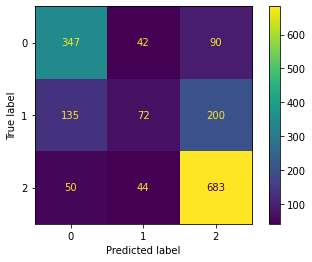

In [48]:
# calling function
model_evaluation(log_model, y_test, X_test)

In [49]:
# feature importances
log_model.coef_

array([[-0.93333693,  0.99699019,  0.00955383,  0.26131454, -0.56236939,
         0.70652753, -0.72193424, -0.82196797, -1.54343907,  1.70170694],
       [-0.13277617, -0.01845158,  0.03923867,  0.14583584,  0.42738363,
         0.06047554,  0.10587147,  0.12525551, -0.20636623, -0.28039482],
       [ 1.0661131 , -0.97853861, -0.04879251, -0.40715037,  0.13498576,
        -0.76700306,  0.61606277,  0.69671246,  1.74980531, -1.42131212]])

66% accuracy for the logistic regression model! That represents a 1% improvement from the decision tree that was inserted into a Grid Search.

### Model 4: Logistic Regression CV (cross-validation)

In this next iteration of modeling, I am trying Logistic Regression but with cross-validation. The difference is that with Logistic Regression CV, the training set is divided into multiple training/validation set combinations. Logistic Regression CV also has a built-in capabilities that automatically selects the best hyper-paramters for the model.

In [50]:
log_model_cv = LogisticRegressionCV(max_iter=200)

log_model_cv.fit(X_train, y_train)

LogisticRegressionCV(max_iter=200)

In [51]:
log_model_cv.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [52]:
# which value of C is the best
log_model_cv.C_

array([0.35938137, 0.35938137, 0.35938137])

In [53]:
# getting best parameters
log_model_cv.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       479
           1       0.46      0.17      0.25       407
           2       0.70      0.88      0.78       777

    accuracy                           0.66      1663
   macro avg       0.60      0.59      0.57      1663
weighted avg       0.63      0.66      0.62      1663



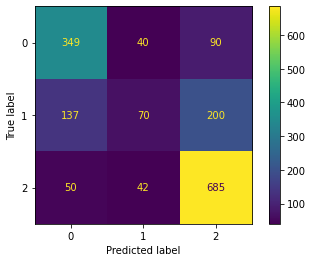

In [54]:
# calling function to get classification report and confusion matrix
model_evaluation(log_model_cv, y_test, X_test)

<b>LogisticRegressionCV</b> feature importances

In [55]:
log_model_cv_coefs = pd.Series(index=X_train.columns, data=log_model_cv.coef_[0])
log_model_cv_coefs

HalfTime_HomeGoals   -0.862963
HalfTime_AwayGoals    0.931569
HalfTime_Result      -0.061927
Home_YellowCs         0.237469
Away_YellowCs        -0.504151
Home_RedCs            0.676734
Away_RedCs           -0.693701
HomeTeam_Favorite    -0.811271
Home_SoT%            -1.409708
Away_SoT%             1.550150
dtype: float64

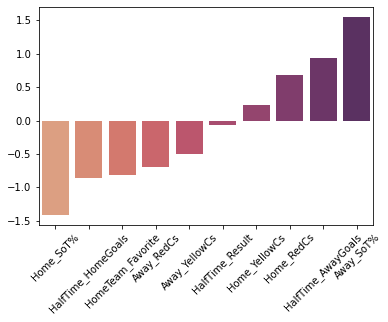

In [56]:
# feature importances
# plt.figure(figsize=(10,6))
log_model_cv_coefs = log_model_cv_coefs.sort_values()
sns.barplot(x=log_model_cv_coefs.index, y=log_model_cv_coefs.values, palette='flare')
plt.xticks(rotation=45)
plt.show()

## Tuned Models

Since the logistic regression model has the best accuracy score so far, I will try a GridSearch to see if I can improve the accuracy score by finding the best hyper-parameters for the model.

### Model 5 - Logistic Regression GridSearch

In [57]:
# new logistic regression instance
log_model_3 = LogisticRegression()

In [58]:
# parameter grid
param_grid_log3 = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

In [59]:
log_model_grid = GridSearchCV(log_model_3,
                              param_grid_log3,
                              scoring='accuracy',
                              n_jobs=1,
                              cv=3)

In [60]:
log_model_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'max_iter': [100, 200, 300],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [61]:
log_model_grid.best_params_

{'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       479
           1       0.47      0.18      0.26       407
           2       0.70      0.88      0.78       777

    accuracy                           0.66      1663
   macro avg       0.61      0.59      0.58      1663
weighted avg       0.63      0.66      0.63      1663



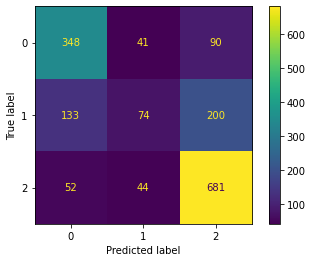

In [62]:
# model performance
model_evaluation(log_model_grid, y_test, X_test)

Looks like Logistic Regression CV and a Logistic Regression GridSearch are having trouble getting past a 66% accuracy. Let's move onto more complex classifier algorithms and see how they perform on the data.

### Model 5 - Random Forest

I am going to try a Random Forest classifier onto the data because a random forest is essentially, a collection of decision trees which is what the baseline model was. The difference is that a random forest randomly selects observations and features to build multiple decision trees from.

In [63]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       479
           1       0.37      0.31      0.33       407
           2       0.72      0.80      0.76       777

    accuracy                           0.63      1663
   macro avg       0.58      0.57      0.57      1663
weighted avg       0.61      0.63      0.62      1663



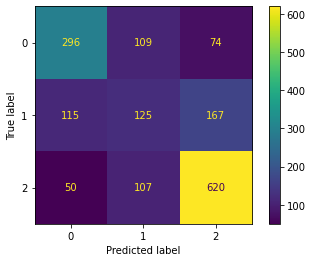

In [64]:
# model evaluation
model_evaluation(rfc, y_test, X_test)

62% accuracy still does not beat our Logistic Regression and LogisticRegression CV models.
I will try to do a GridSearch to find the best performing hyper-parameters for a Random Forest model.

### Model 6 - Random Forest GridSearch

In [65]:
rfc2 = RandomForestClassifier()

In [66]:
# parameter grid
forest_param = {'n_estimators':[50,100,200],
                'criterion':['gini','entropy']}

In [67]:
rfc_grid = GridSearchCV(rfc, 
                        forest_param,
                        scoring='accuracy',
                        cv=5)

In [68]:
rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

              precision    recall  f1-score   support

           0       0.64      0.61      0.63       479
           1       0.38      0.32      0.35       407
           2       0.71      0.80      0.75       777

    accuracy                           0.63      1663
   macro avg       0.58      0.58      0.58      1663
weighted avg       0.61      0.63      0.62      1663



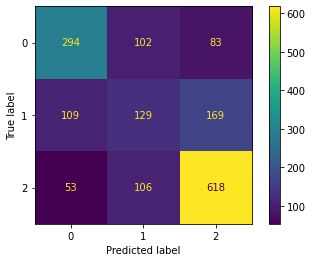

In [69]:
model_evaluation(rfc_grid, y_test, X_test)

In [70]:
rfc_grid.best_params_

{'criterion': 'gini', 'n_estimators': 200}

Still not seeing the improvement from the baseline model that I am hoping for so we will continue to try different models. Let's take a look at how a Support Vector Machine and an XGBoost performs.

### Model 7 - Support Vector Machine

In [71]:
# SVC instance
# using class_weight = 'balanced' because our target class is imbalanced
svc = SVC(class_weight='balanced')

In [72]:
svc.fit(X_train, y_train)

SVC(class_weight='balanced')

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       479
           1       0.35      0.53      0.42       407
           2       0.83      0.63      0.72       777

    accuracy                           0.60      1663
   macro avg       0.61      0.59      0.59      1663
weighted avg       0.66      0.60      0.62      1663



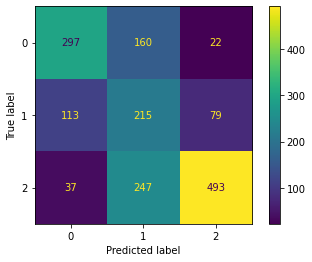

In [73]:
model_evaluation(svc, y_test, X_test)

60% accuracy with no parameters set. Let's try and put the svc in a GridSearch and see if the performance improves.

### Model 8 - Support Vector Machine GridSearch

In [74]:
svc2 = SVC(class_weight='balanced')

In [75]:
# use grid search to find the best parameters for SVC
param_grid_svc = {'C':[0.001,0.01,0.1,0.5,1],'gamma':['scale','auto']}

In [76]:
svc_grid = GridSearchCV(svc2, param_grid_svc)

In [77]:
svc_grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [78]:
svc_grid.best_params_

{'C': 1, 'gamma': 'scale'}

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       479
           1       0.35      0.53      0.42       407
           2       0.83      0.63      0.72       777

    accuracy                           0.60      1663
   macro avg       0.61      0.59      0.59      1663
weighted avg       0.66      0.60      0.62      1663



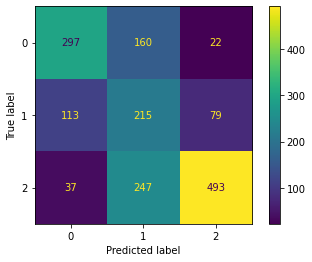

In [79]:
model_evaluation(svc_grid, y_test, X_test)

Same exact score as before... let's move onto XGBoost

XGBoost is an ensemble method that focuses on extreme gradient boosting. This algorithm is regularly the top-performing model in machine-learning competitions like the ones on Kaggle.

### Model 9 - XGBoost

In [80]:
# XGBoost instance
xgb = XGBClassifier()

In [81]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       479
           1       0.39      0.36      0.37       407
           2       0.73      0.80      0.76       777

    accuracy                           0.63      1663
   macro avg       0.59      0.59      0.59      1663
weighted avg       0.63      0.63      0.63      1663



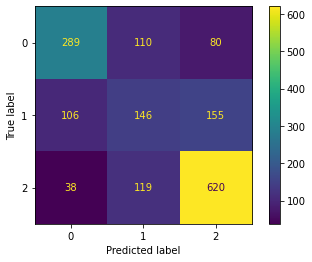

In [82]:
model_evaluation(xgb, y_test, X_test)

No luck getting a better accuracy with an XGBoost classifier, only 63% accuracy. Let's see if finding the best parameters of an XGBoost classifier will help the model performance.

### Model 10 - XGBoost GridSearch

In [83]:
xgb2 = XGBClassifier()

In [84]:
param_grid_xgb = {
    'learning_rate': [0.1,0.3,0.5],
    'max_depth': [1,3,5],
    'min_child_weight': [1,3,5],
    'subsample': [0.5, 0.7],
    'n_estimators': [10,50,100],
}

In [85]:
grid_xgb = GridSearchCV(xgb2, param_grid_xgb, scoring='accuracy', n_jobs=1)
grid_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [86]:
grid_xgb.best_params_

{'learning_rate': 0.3,
 'max_depth': 1,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 0.7}

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       479
           1       0.39      0.25      0.31       407
           2       0.74      0.84      0.79       777

    accuracy                           0.65      1663
   macro avg       0.59      0.59      0.58      1663
weighted avg       0.62      0.65      0.63      1663



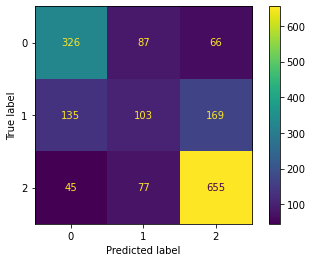

In [87]:
model_evaluation(grid_xgb, y_test, X_test)

Still no score better than our earlier logistic regression models! It seems that our best performing model was one of the first ones tried on the data, logistic regression.

# Conclusion
Out of all the models that I tried on the dataset, the model that achieved the highest accuracy was a logistic regression model. A logistic regression model was able to acheive an accuracy of 66% on the test data. This model will allow bettors to identify the feature of a Premier League match that are most determinant in the full-time match result. Using this analysis, bettors can wager their money based on data, not on their own intution and biases.

I recommend that bettors of Premier League matches should focus on placing bets when there is a team (home or away) winning at half-time. Overall, home-teams that were winning at half-time went onto win the game at full-time at a 81% rate. When away-teams were winning at half-time, they went onto win the game at full-time at a 70% rate. These recommendations should not be relied on to win the bet every-time, only to increase the chances of winning based on the data analysis.

## Future Research
In the history of the Premier League, there are the 'Big Six' clubs that traditionally have had the most success because their owners invest the most money compared to the clubs outside of the ‘Big Six’. These clubs are Manchester United, Liverpool, Arsenal, Chelsea, Manchester City, and Tottenham. Since these clubs are almost always the betting favorite when not playing one another, it would be interesting to look at their performances and seeing if there’s a difference in how they perform when they are the favorites compared to when non-Big Six clubs are the favorites.

Also, I would be interested in incorporating stats at half-time in future research. The dataset I used was limited in that it only provided stat totals at the end of each match. But because half-time result was such a key feature, I would want to see if adding half-time stats to the dataset could improve the model's accuracy in predicting results at full-time.

Finally, I would want to look at the effects of the COVID-19 season. There was nearly a whole season of data where the teams did not get true home-field advantage due to the pandemic which caused matches to be played in empty stadiums without fans. In future research, I could explore the differences in how betting favorites performed during this season or even take these games out entirely and see if the model's performance would improve.